# 3. Text Generation
In this notebook we will carry out the same tweet bias classification task but using text generation instead of feature extraction. Specifically, we will employ zero-shot and few-shot classification using a pre-trained text generation LLM.

By the end of this notebook, you will be able to:
- Load a pre-trained causal LLM for text generation and run it on a GPU. 
- Implement zero-shot and few-shot classification and understand the difference between the two.

## Environment Setup
Make sure to set your runtime to use a GPU by going to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `T4 GPU`

In [ ]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Installing requisite packages
    !pip install transformers accelerate pymupdf &> /dev/null

    # Change working directory
    %cd /content/drive/MyDrive/LLM4SciSci

In [2]:
import pandas as pd
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch
import os
import fitz
from tqdm.notebook import tqdm_notebook as tqdm

## Assigning interpretable labels to clusters

We begin by loading the dataset as a `pandas.DataFrame`:

In [3]:
data = pd.read_csv('science_of_science_clusters.csv')
data['cluster'] = data['cluster'].astype(str)
data

,title,abstract,keywords,year,citations,text,cluster
0,Machine learning misclassification networks re...,Given a large enough volume of data and precis...,Interdisciplinary research; Machine learning; ...,2024,3,Machine learning misclassification networks re...,4
1,Dynamic patterns of the disruptive and consoli...,Scientific breakthroughs possess the transform...,citation network; disruption; Nobel Prize; sci...,2024,2,Dynamic patterns of the disruptive and consoli...,4
2,Automating the practice of science: Opportunit...,Automation transformed various aspects of our ...,AI for science; automation ; computational sci...,2025,1,Automating the practice of science: Opportunit...,0
3,Asian American Representation Within Psycholog...,"As a racial group, Asians are incredibly diver...",Asian/Asian American; diversity; intersectiona...,2024,1,Asian American Representation Within Psycholog...,2
4,Bibliometric analysis of publications on trabe...,"Purpose: Trabecular bone score (TBS), as a tex...",Bone mineral density; Fracture risk; Knowledge...,2024,0,Bibliometric analysis of publications on trabe...,1
...,...,...,...,...,...,...,...
1119,The science of science foundation,[No abstract available],NaN,1965,1,The science of science foundation./n/n[No abst...,3
1120,Bibliographic coupling: A review,The theory and practical applications of bibli...,NaN,1974,224,Bibliographic coupling: A review./n/nThe theor...,1
1121,Behavioristisk kritik av psykoanalysen,"As fas as metascience is concerned, Schioldbor...",NaN,1971,3,Behavioristisk kritik av psykoanalysen./n/nAs ...,2
1122,The R & D information gap or the social scienc...,[No abstract available],NaN,1967,0,The R & D information gap or the social scienc...,0


In [ ]:
# Sample 50 titles from each cluster
cluster_titles = {}
for cluster in data['cluster'].unique():
    sampled_titles = (
        data.query('cluster == @cluster')['title']
        .sample(n=20, random_state=42)
    )
    sampled_titles = sampled_titles.str.cat(sep='.\n\n')
    cluster_titles[cluster] = sampled_titles

print(cluster_titles['0'])

The code next loads the LLM and its corresponding tokenizer. We will use [`"meta-llama/Llama-3.2-3B-Instruct"`](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), a recent model trained which shows impressive performance given its relatively small size. The smaller size has the main advantage that it can be run on the freely available GPUs on Google Colab.

The code begins by setting the random seed. This helps ensure the reproducibility of the often stochastic processes involved in training and running LLMs. **It next asks you to provide your [Hugging Face access token](https://huggingface.co/settings/tokens), which you will need to copy-paste in order to download the model.** The code then loads the model and tokenizer. The model is loaded onto the GPU via `device_map="cuda"` and the model is set to use half-precision via `torch_dtype=torch.float16` to save memory (RAM). The `trust_remote_code=True` argument is used to trust the remote code, and `attn_implementation='eager'` is used for faster inference on the T4 GPUs available on Google Colab.

In [ ]:
torch.random.manual_seed(42) # For reproducibility

access_token = 'your_access_token_here'

model_ckpt = 'meta-llama/Llama-3.2-1B-Instruct'
# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_ckpt,
    device_map="cuda", # Use GPU
    torch_dtype=torch.float16, # Use half-precision
    trust_remote_code=True,
    attn_implementation='eager', # For faster inference on T4 GPUs
    token=access_token
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_ckpt,
    token=access_token,
)


The code next initializes a `transformers` pipeline for text generation. This is a high-level API that allows for easy text generation using the pre-trained models. We will use this pipeline to classify the tweets as either `"neutral"` or `"partisan"` using zero-shot classification. The pipeline takes two arguments in addition to the task (`"text-generation"`):

1. `model`: The model to use for text generation.
2. `tokenizer`: The tokenizer to use for text generation.

In [ ]:
# Initialize pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Since we only want the model to output either `"neutral"` or `"partisan"`, the code provides a hard constraint on the generation by setting `"max_new_tokens": 10` and `"do_sample": False`. This is done in the `generation_args` dictionary, which is later feed into the text generation `pipe`. It also sets `"temperature"` and `"top_p"` to `None`, since these parameters do not apply when `do_sample=False`. The `pad_token_id` is set to the end-of-sequence token ID, which is recommended when using the Hugging Face pipeline for text generation. As a final piece of setup, we also add a soft constraint by prompting the model to `"Strictly answer with only 'neutral' or 'partisan'"`:

In [ ]:
# Text generation arguments
generation_args = {
    "max_new_tokens": 50,
    "return_full_text": False,
    "do_sample": False,
    "temperature": None,
    "top_p": None,
    "pad_token_id": pipe.tokenizer.eos_token_id
}

system_prompt = "You are a metascience expert who specializes in assigning faithful and informative labels to clusters of article titles."

user_prompt_template = """
Which themes describe the following cluster of articles?
--------------------------
{}
--------------------------
Provide 3-5 main themes, each seperated by a comma. Do NOT provide any other output.
"""
cluster_labels = {}
for cluster, titles in cluster_titles.items():
    user_prompt = user_prompt_template.format(titles)

    message = [
        {'role': 'system', 'content': system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # Generate text and access output at index 0 at key 'generated_text'
    output = pipe(message, **generation_args)[0]['generated_text']

    cluster_labels[cluster] = output

cluster_labels

Although model outputs are relatively faithful and descriptive, the model does not appear to be obeying instructions properly in the sense that it is providing many more themes than the 3-5 it was instructed to provide.


**TASK 1**: Play around with the `system_prompt` and `user_prompt_template` in order to make the model really only provide 3-5 themes. For instance, try moving the '3-5 themes' instruction to the system prompt. Why might this help?

**TASK 2**: Try increasing the model size from 1B to 3B parameters (switch `model_ckpt` from `'meta-llama/Llama-3.2-1B-Instruct'` to `'meta-llama/Llama-3.2-3B-Instruct'`. Is the larger model better at following the task instructions?

## Information extraction from article PDFs

In [ ]:
model_ckpt = 'meta-llama/Llama-3.2-1B-Instruct'

# Load the model in 1B again
model = AutoModelForCausalLM.from_pretrained(
    model_ckpt,
    device_map="cuda", # Use GPU
    torch_dtype=torch.float16, # Use half-precision
    trust_remote_code=True,
    attn_implementation='eager', # For faster inference on T4 GPUs
    token=access_token
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_ckpt,
    token=access_token,
)

# Initialize pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

# Text generation arguments
generation_args = {
    "max_new_tokens": 50,
    "return_full_text": False,
    "do_sample": False,
    "temperature": None,
    "top_p": None,
    "pad_token_id": pipe.tokenizer.eos_token_id
}

In [ ]:
file_names = os.listdir('SciSci_articles')
file_names.remove('.DS_Store') if '.DS_Store' in file_names else None

system_prompt = "You are a metascience expert who specializes in identifying whether an article uses bibliometric analysis or not."
user_prompt_template = """
Does the following article use bibliometric analysis? First provide your judgement in all caps (TRUE/FALSE/UNCLEAR), then provide a few sentences extracted from the article that support your judgement. Here is the article:

{}
"""
n_pages = 4
outputs = {}
for file_name in tqdm(file_names):
    print(file_name)
    pdf = fitz.open(f'SciSci_articles/{file_name}')
    text = '\n\n---page break---\n\n'.join([page.get_text() for page in pdf[:n_pages]])

    user_prompt = user_prompt_template.format(text)
    message = [
        {'role': 'system', 'content': system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # Generate text and access output at index 0 at key 'generated_text'
    output = pipe(message, **generation_args)[0]['generated_text']

    outputs[file_name] = output

In [21]:
predictions = {}
for f_name, output in outputs.items():

    if 'TRUE' in output and 'FALSE' not in output:
        prediction = 'TRUE'
    elif 'FALSE' in output and 'TRUE' not in output:
        prediction = 'FALSE'
    elif 'UNCLEAR' in output:
        prediction = 'UNCLEAR'
    else:
        prediction = 'NaN'

    predictions[f_name] = prediction

predictions = pd.Series(list(predictions.values()), dtype=str)
predictions.hist()

NameError: name 'outputs' is not defined

Unfortunately, this distribution doesn't look very similar to the number of times 'bibliometric' appears in the global set of article keywords (below). The model also doesn't appear to be making much use of the `'UNCLEAR'` category, and there are some missing judgements (`'NaN'`s).


<Axes: >

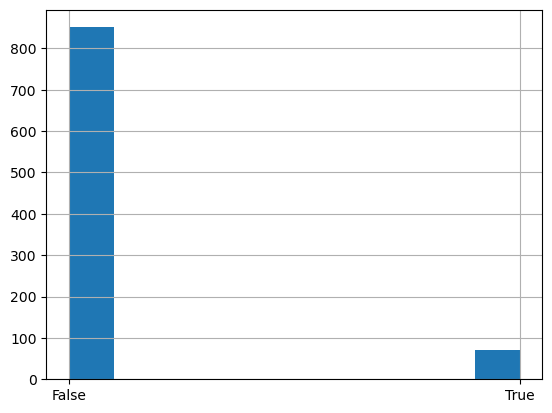

In [22]:
# Plotting the global distribution of 'bibliometric' keyword occurrences
data['keywords'].dropna().str.lower().str.contains('bibliometric').astype(str).hist()

**Group challenge**: Split into teams of 3/4 people. As a group, inspect the outputs below to get an idea for what might be going wrong. Then try playing around with the prompt to see if you can improve the quality of the output distribution. Some ideas might be:

- Explicitly encouraging the model to use the 'UNCLEAR' category when it isn't absolutely sure that the article used bibliometric analysis.
- Providing a definition of bibliometric analysis in the prompt.
- Switching `pdf[:n_pages]]` to something like `pdf[start_page: start_page + n]]` with the goal of increasing the likelihood that the paper's methods section is captured in the page slice (instead of the title/abstract/introduction that is implicitly the focus at present).
- Forcing the model to use chain-of-thought (or "chain-of-evidence") by asking it to provide the evidence for its judgement *before* it provides its judgement (tip: you will have to increase `"max_new_tokens"` to ensure that the judgement still makes it in to the model output).

Tip: Processing all 30 articles on each attempt can take a while. To speed up your efforts, consider trying out different ideas in parallel.

May the best team win ;)

In [ ]:
outputs